In [1]:
import numpy as np
from matplotlib import pyplot as plt
import theano as th
from theano import tensor as tt
from theano.tensor.shared_randomstreams import RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import raw_random

In [2]:
rng = RandomStreams()

In [3]:
th.config.floatX = 'float32'
#th.config.exception_verbosity = 'high'

In [4]:
N_particles = 600
transition_std = 0.03
emission_std = 0.1
def transition_det(x):
    return x/2 + (10*x)/(1+x)

def transition(x):
    return transition_det(x) + rng.normal(std=transition_std, size=x.shape)

def emission_det(x):
    return x**2/20

def emission(x):
    return emission_det(x) + rng.normal(std=emission_std, size=x.shape)

In [5]:
inp = tt.vector(name='default input vector')

In [6]:
get_transition = th.function([inp], transition(inp), allow_input_downcast=True)
get_emission = th.function([inp], emission(inp), allow_input_downcast=True)

In [7]:
latent = [20.1]
for _ in range(1000):
    latent.append(get_transition(np.array([latent[-1]]))[0])

observe = get_emission(np.array(latent))

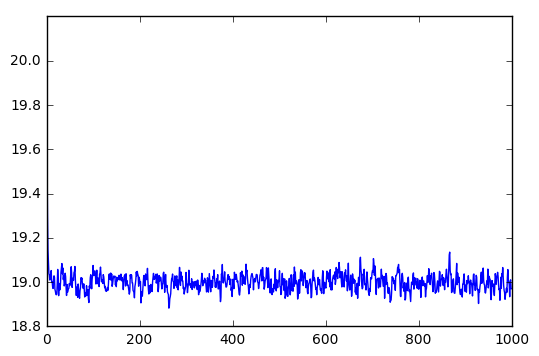

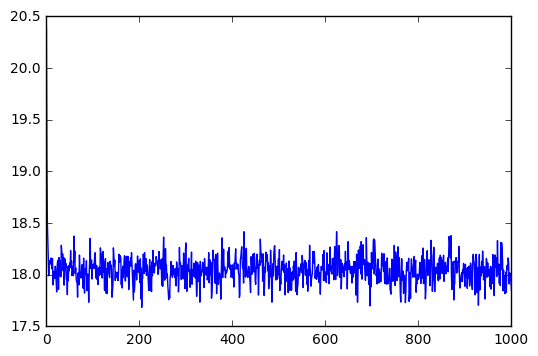

In [8]:
plt.plot(latent)
plt.show()
plt.plot(observe)
plt.show()

In [9]:
def prob(x, observation):
    pre = tt.exp(-(emission_det(x) - observation)**2/(2*emission_std**2))
    return pre/pre.sum()

def resample(x, probs):
    return rng.choice(a=tt.arange(x.shape[0]), p=probs, replace=True, size=(N_particles,), dtype='int64').T

def update(x):
    res, updates = th.scan(transition, non_sequences=x, n_steps=10)
    return res.reshape((-1,))[:N_particles]

In [10]:
observe_th = th.shared(np.array(observe), name='observe')
init_sample = th.shared(np.random.normal(scale=3,size=(N_particles,)), name='current sample')

In [11]:
def filt_iter (observation, x, y):
    probs = prob(y,observation)
    res = resample(y,probs)
    probs = probs[res]
    return y[res], update(x), probs/probs.sum()

results, updates = th.scan(filt_iter,
                           outputs_info = [{'initial':init_sample[:N_particles]},{'initial':init_sample}, None],
                           sequences=observe_th)
results = [results[0], results[2]]

In [12]:
filtered = th.function([], results, updates=updates)

In [13]:
filt_distrib, filt_distrib_probs = filtered()

In [14]:
filt_distrib.shape

(1001, 600)

In [15]:
filt_distrib = np.array(filt_distrib)
filt_distrib = np.sort(filt_distrib, axis=1)

In [16]:
def pxtp1x (x2,x1):
    return tt.exp(-(transition_det(x1)-x2)**2/(2*transition_std**2))

In [17]:
def denum(xtp1, x, wt):
    return (wt.reshape((1,-1))*pxtp1x(xtp1.reshape((1,-1)), x.reshape((-1,1)))).sum(axis=0)

In [18]:
def intersum_no_denum(xtp1, x, next_wT):
    return next_wT.reshape((1,-1))*pxtp1x(xtp1.reshape((1,-1)), x.reshape((-1,1)))

In [19]:
filt_distrib_th = th.shared(filt_distrib, name='filtered distribution')
filt_distrib_probs_th = th.shared(filt_distrib_probs, name='filtered distrib probabilities')

In [20]:
def interfun(xtp1, x, wt, next_wT):
    s = tt.sum((intersum_no_denum(xtp1, x, next_wT).T/denum(xtp1, x, wt)).T, axis=1)
    s = s*wt
    return s/s.sum()

In [21]:
results, updates = th.scan(interfun, 
                           outputs_info=[filt_distrib_probs_th[-1]],
                           go_backwards=True,
                           sequences=[filt_distrib_th[:-1], 
                                      filt_distrib_th[1:], 
                                      filt_distrib_probs_th[1:]])

In [22]:
smoother = th.function([], results[::-1], updates=updates)

In [23]:
%time smoothed = smoother()

CPU times: user 5.67 s, sys: 24 ms, total: 5.69 s
Wall time: 5.71 s


In [24]:
smoothed.shape

(1000, 600)

In [25]:
filt_distrib = filt_distrib[1:]

In [26]:
smm = []
for i in range(smoothed.shape[0]):
    smm.append(np.random.choice(filt_distrib[i], p=smoothed[i], size=100, replace=True))
smm = np.array(smm)
smm = np.sort(smm, axis=1)

In [27]:
filt_distrib.shape

(1000, 600)

In [28]:
p = 0.15
dfilt = int(p*filt_distrib.shape[1])
dsm = int(p*smm.shape[1])

Filtered:


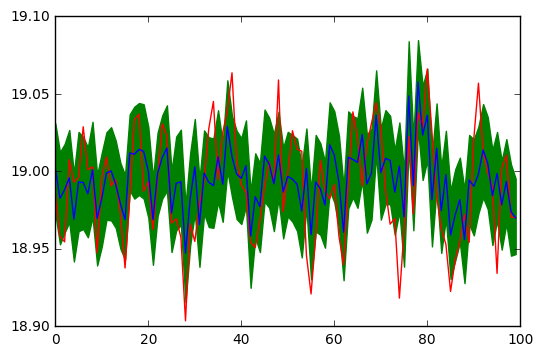

Smoothed:


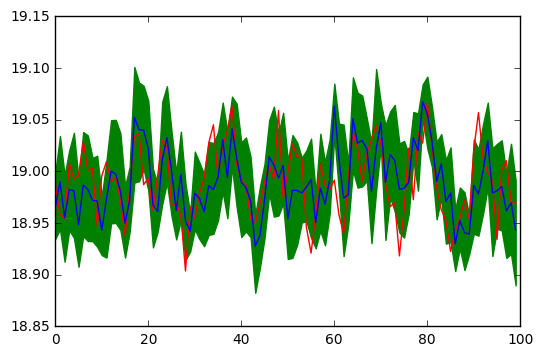

In [29]:
print('Filtered:')
plt.fill_between(range(100),filt_distrib[-100:,dfilt],filt_distrib[-100:,-dfilt],color='green')
plt.plot(latent[-100:],color='red')
plt.plot(filt_distrib.mean(axis=1)[-100:], color='blue')
plt.show()

print('Smoothed:')
plt.fill_between(range(100),smm[-100:,dsm], smm[-100:,-dsm], color='green')
plt.plot(latent[-100:],color='red')
plt.plot(np.mean(smm[-100:], axis=1), color='blue')
plt.show()